In [545]:
# Importing Packages
import numpy as np
import pandas as pd

# Packages to scrape the data
import gzip
import requests
from io import BytesIO

# Packages to create and deal with our time variables
import pytz
from datetime import datetime, timedelta, date

# Packages to model and plot our data
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [505]:
# Setting up the format for the data scrape and data frame
url = "https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/{year}/725090-14739-{year}.gz"
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
colnames = ["Year", "Month", "Day", "Hour", "Air Temp", "Dew Temp", "Sea Level Pressure", 
        "Wind Direction", "Wind Speed", "Total Cloud Cover", "1hr Acc Precip", "6hr Acc Precip"]

# Looping through the years 
for i in years:
    urls = url.format(year = i)
    response = requests.get(urls)

    # Loading data into pandas dataframe 
    with gzip.GzipFile(fileobj=BytesIO(response.content)) as f:
        df = pd.read_csv(f, delim_whitespace = True, header = None, names = colnames)  
    
    # Aggregating the different years into a list
    dfs.append(df)

# Combining all our data and checking if the dates make sense
df = pd.concat(dfs, ignore_index= True)
print(df.head())
df.tail()


   Year  Month  Day  Hour  Air Temp  Dew Temp  Sea Level Pressure  \
0  2019      1    1     0        56       -17               10248   
1  2019      1    1     1        39         0               10233   
2  2019      1    1     2        33        11               10208   
3  2019      1    1     3        28        11               10187   
4  2019      1    1     4        33        17               10172   

   Wind Direction  Wind Speed  Total Cloud Cover  1hr Acc Precip  \
0             160          46                  8           -9999   
1             140          57              -9999               5   
2             130          62              -9999              10   
3             140          67                  8              18   
4             140          62              -9999              23   

   6hr Acc Precip  
0              -1  
1           -9999  
2           -9999  
3           -9999  
4           -9999  


,Year,Month,Day,Hour,Air Temp,Dew Temp,Sea Level Pressure,Wind Direction,Wind Speed,Total Cloud Cover,1hr Acc Precip,6hr Acc Precip
43813,2023,12,31,19,33,-39,10128,260,31,-9999,0,-9999
43814,2023,12,31,20,39,-39,10129,290,51,-9999,0,-9999
43815,2023,12,31,21,33,-39,10132,280,36,4,0,-9999
43816,2023,12,31,22,33,-44,10136,310,31,-9999,0,-9999
43817,2023,12,31,23,28,-39,10144,350,46,-9999,0,-9999


In [506]:
# Converting Air Temp, and Dew Temp to Fahrenheit and Converting Wind Speed
df["Air Temp"] = ((df["Air Temp"] / 10) * (9/5)) + 32
df["Dew Temp"] = ((df["Dew Temp"] / 10) * (9/5)) + 32
df["Wind Speed"] = df["Wind Speed"] / 10

In [507]:
# Checking for missing temperature data
# According to documentation, missing data is coded as -9999, so we will adjust accordingly
df.replace(-9999, np.nan, inplace = True)
print(df["Air Temp"].isnull().sum())
print(df["Dew Temp"].isnull().sum())
print(df["Air Temp"].isna().sum())
print(df["Dew Temp"].isna().sum())

# Check other columns, drop if more missing proportion is more than .5 and interpolate otherwise
for name in colnames:
    if df[name].isnull().mean() > .5:
        df = df.drop(name, axis =  1)
    elif df[name].isnull().mean() < .5 and df[name].isnull().mean() > 0:
        df[name].interpolate(inplace = True)

# Mean Air Temp for July 2021
July2021 = df[(df["Year"] == 2021) & (df["Month"] == 7)]["Air Temp"].mean()
July2021


0
0
0
0


71.83491935483872

In [508]:
# Create a datetime column and convert to EPT
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour"]])
df["Date"] = df["Date"].dt.tz_localize("UTC").dt.tz_convert("America/New_York")

# Function to categorize correct gas dates
def gas_day(time):
    if time.hour <= 9:
        return time.date() - timedelta(days=1)
    else:
        return time.date()

# Creating gas dates and daily data
df["Gas Day"] = df["Date"].apply(gas_day)
daily_df = df.groupby("Gas Day").mean()
daily_df.index = pd.to_datetime(daily_df.index)

# Dropping columns that have lost meaning
daily_df = daily_df.drop(columns = ["Year", "Month", "Day", "Hour", "Date"])

# Boston gas day temp for 07/04/2020
daily_df.loc["2020-07-04"]["Air Temp"]

66.7625

In [509]:
# Loading demand data and creating total column
demand_df = pd.read_excel("agt.xlsx")
demand_df["Total"] = demand_df["Residential/Commercial"] + demand_df["Power Plant"]
print(demand_df.head())
print(demand_df.tail())

# Adjust rows of daily data to match with response variable and join on same index
daily_df = daily_df.loc["2019-01-01":"2022-12-31"]
demand_df = demand_df.set_index("Date")
daily_df["Demand"] = demand_df["Total"]
daily_df.head()

        Date  Residential/Commercial  Power Plant     Total
0 2019-01-01                1135.967      453.665  1589.632
1 2019-01-02                1327.635      469.363  1796.998
2 2019-01-03                1185.310      455.902  1641.212
3 2019-01-04                1093.767      463.410  1557.177
4 2019-01-05                1134.977      435.882  1570.859
           Date  Residential/Commercial  Power Plant     Total
1456 2022-12-27                1556.751      235.579  1792.330
1457 2022-12-28                1343.286      331.574  1674.860
1458 2022-12-29                1172.543      307.326  1479.869
1459 2022-12-30                 875.331      315.940  1191.271
1460 2022-12-31                 731.545      297.038  1028.583


,Air Temp,Dew Temp,Sea Level Pressure,Wind Direction,Wind Speed,Total Cloud Cover,1hr Acc Precip,Demand
Gas Day,,,,,,,,
2019-01-01,40.3325,23.2550,10152.916667,312.500000,7.208333,3.333333,0.000000,1589.632
2019-01-02,34.0550,17.6150,10212.666667,156.875000,3.587500,6.416667,0.000000,1796.998
2019-01-03,39.6125,25.6025,10130.083333,265.625000,4.854167,5.458333,0.083333,1641.212
2019-01-04,42.2300,30.0800,10085.625000,194.166667,4.266667,7.166667,0.375000,1557.177
2019-01-05,39.2300,33.9425,10023.166667,237.083333,4.850000,5.500000,5.083333,1570.859


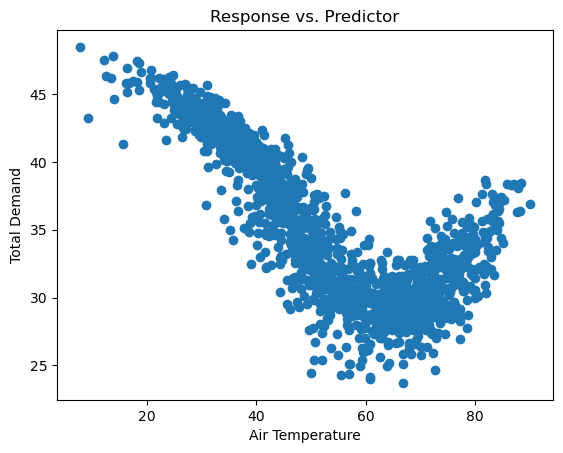

In [529]:
# Checking for relationships
# Seems that our temperature variables are non-linearly related with demand
# Best to use a model that can handle this relationship like a tree-based model
plt.scatter(daily_df["Air Temp"], daily_df["Demand"])
plt.xlabel("Air Temperature")
plt.ylabel("Total Demand")
plt.title("Response vs. Predictor")
plt.show()

0.888858035312891
                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     2197.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:50:10   Log-Likelihood:                -7061.1
No. Observations:                1096   AIC:                         1.413e+04
Df Residuals:                    1092   BIC:                         1.415e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2158.2991    100.039  

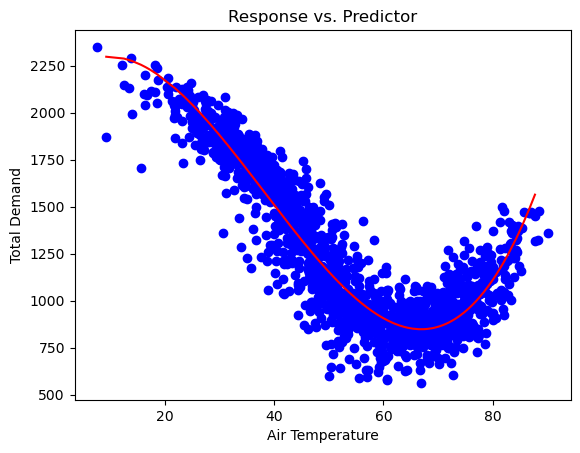

In [583]:
# Split data according to time frame we want to forecast (2022)
X_train = daily_df[:'2021-12-31'].drop("Demand", axis = 1) 
Y_train = daily_df.loc[:'2021-12-31', "Demand"]
X_test = daily_df["2022-01-01":].drop("Demand", axis = 1) 
Y_test = daily_df.loc["2022-01-01":, "Demand"]

# CHECK ASSUMPTIONS
# Fitting polynomial regression
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_train[["Air Temp"]])
X_poly = sm.add_constant(X_poly)  
model = sm.OLS(Y_train, X_poly).fit()
print(model.summary())

# Prediction
X_test_poly = poly.fit_transform(X_test[["Air Temp"]])
X_test_poly = sm.add_constant(X_test_poly)
Y_pred = model.predict(X_test_poly)
OSR2 = r2_score(Y_test, Y_pred)
print(OSR2)

# Plotting model
plt.scatter(daily_df["Air Temp"], daily_df["Demand"], color = "blue")
idx = np.argsort(X_test["Air Temp"].values)
plt.plot(X_test["Air Temp"].values[idx], Y_pred[idx], color = "red")
plt.xlabel("Air Temperature")
plt.ylabel("Total Demand")
plt.title("Response vs. Predictor")
plt.show()

0.9003310835178285
0.8724133041217873


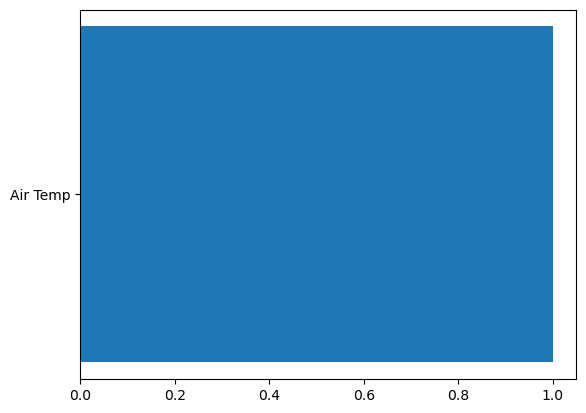

In [596]:
# Heurisitc for max depth
depth = int(round(np.log(len(X_train)), 0))

# Fitting regression tree
reg_tree = DecisionTreeRegressor(random_state = 42, max_depth = depth)
reg_tree.fit(X_train[["Air Temp"]], Y_train)

# Prediction
Y_pred_train = reg_tree.predict(X_train[["Air Temp"]])
R2 = r2_score(Y_train, Y_pred_train)
print(R2)
Y_pred_test = reg_tree.predict(X_test[["Air Temp"]])
OSR2_2 = r2_score(Y_test, Y_pred_test)
print(OSR2_2)

# Checking features
# Clearly air temp explains the majority of the variability
importances = reg_tree.feature_importances_
index = np.argsort(importances)
plt.barh(y = X_test.columns[index], width = importances[index])
plt.show()

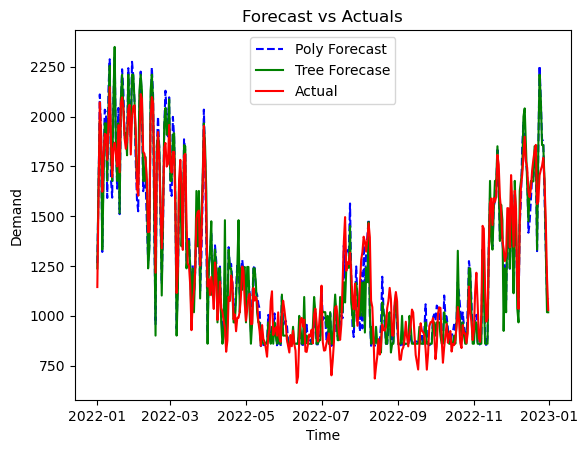

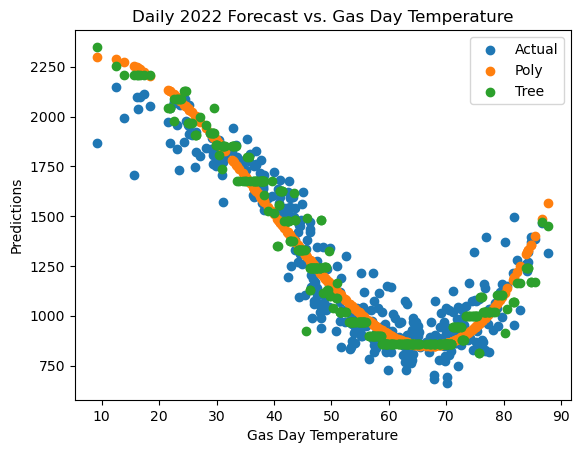

In [602]:
# Line plot of predictions against actuals
plt.plot(Y_test.index, Y_pred, label = "Poly Forecast", color = "b", linestyle = "--")
plt.plot(Y_test.index, Y_pred_test, label = "Tree Forecase", color = "g", linestyle = "-")
plt.plot(Y_test.index, Y_test, label = "Actual", color = "r")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Forecast vs Actuals")
plt.show()

# Scatter plot of predictions against temp data
plt.scatter(X_test["Air Temp"], Y_test, label = "Actual")
plt.scatter(X_test["Air Temp"], Y_pred, label = "Poly")
plt.scatter(X_test["Air Temp"], Y_pred_test, label = "Tree")
plt.legend()
plt.xlabel("Gas Day Temperature")
plt.ylabel("Predictions")
plt.title("Daily 2022 Forecast vs. Gas Day Temperature")
plt.show()